In [140]:
import networkx as nx
import gurobipy as gb
import matplotlib.pyplot as plt
import os

In [141]:
def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, pos=pos, node_shape='o', node_size=600, node_color='red')
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    nx.draw_networkx_nodes(G, pos=pos, node_shape='o', node_size=600, node_color='red', label=[G.nodes()])
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos, edgelist=[(u,v)], edge_color='r')
            nx.draw_networkx_edge_labels(G, pos=pos, edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos, edgelist=[(u,v)], edge_color='k')
        
    #edges_in_sol = [(u,v)  for u,v in G.edges() if x[u,v].x > 0.1]

    plt.axis('off')
    plt.show()
    
def DrawSolFlow (G,x,f):
    
    plt.figure(figsize=args.figsize)
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, pos=pos, node_shape='o', node_size=600, node_color='r', label=[G.nodes()])
    nx.draw_networkx_nodes(G, pos=pos, nodelist = [root], node_shape='o', node_size=600, node_color='k', label=[G.nodes()])
    nx.draw_networkx_labels(G, pos=pos, font_color='w')
    
    for h,k in G.edges():
        flow = abs(f[h,k].x - f[k,h].x)
        G[h][k]['capacity'] = x[h,k].x
        
        if x[h,k].x > 0.00001:
            if x[h,k].x > 0.999999:
                nx.draw_networkx_edges(G, pos=pos, edgelist=[(h,k)], edge_color='k')
                nx.draw_networkx_edge_labels(G, pos=pos, edge_labels={(h,k):'{:.2f}'.format(flow)})
            else:
                nx.draw_networkx_edges(G, pos=pos, edgelist=[(h,k)], edge_color='r')

    plt.axis('off')
    plt.show()
    
class args:
    filename = None
    figsize = 30,60
    scale = 40

#  Minimum Spanning Tree Problem 
## Single commodity flow formulation

$$
x_e = \begin{cases}
1 \text{ if edge $e$ is in the tree} \\
0 \text { otherwise}
\end{cases}
$$

Associate to each edge $e$ two directed arcs $(i,j)$ and $(j,i)$ and let 

$$
f_{ij} = \{\text{flow carried by the arc} (i,j)\}
$$

\begin{alignat}{3}
\min cx &&\\
\sum_{e \in E} x_e = n - 1 && \\
\sum_{j \in \delta^+(0)} f_{0j} - \sum_{j \in \delta^-(0)} f_{j0} = n - 1 &&\\
\sum_{j \in \delta^-(v)} f_{jv} - \sum_{j \in \delta^+(v)} f_{vj} = 1 &&\;\; \forall v \in V, v \not = \{0\} \\
f_{ij} \le (n-1)x_e &&\;\; \forall e \in E, e=\{i,j\}\\
f_{ji} \le (n-1)x_e &&\;\; \forall e \in E, e=\{i,j\}\\
f \ge 0, \; x_e \in \{0,1\}
\end{alignat}

In [142]:
args.filename = "network1.gml"
args.scale = 20
args.figsize = (15,15)

basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 15 nodes and 105 edges


## **Ex.1.1 ->** Find the set of links that connects all nodes at minimum cost

In [143]:
root = 0
G = nx.convert_node_labels_to_integers(G, first_label=root,label_attribute='old' )
D = G.to_directed() # make a directed copy of G

In [144]:
mstflow = gb.Model()

## Variables

x = mstflow.addVars(G.edges(), obj=[G[u][v]['cost'] for u,v in G.edges()],
                    ub = 1.0,
                    vtype=gb.GRB.BINARY,
                    name='x')

f = mstflow.addVars(D.edges(), ub=G.number_of_nodes(), vtype=gb.GRB.CONTINUOUS, name='f')

## constraints

mstflow.addConstr(x.sum() == G.number_of_nodes() - 1, 'Cardinality')

mstflow.addConstr(f.sum(root, '*') - f.sum('*', root) == G.number_of_nodes() - 1, 'Flow_at_root')

# Root is the first nodes the iterator moves one step ahead
for v in G.nodes():
    if v != root:
        name = 'Balance_' + str(v)
        mstflow.addConstr(f.sum('*',v) - f.sum(v,'*') == 1, name=name)
    
for e in G.edges():
    
    h = e[0]
    k = e[1]
        
    name = "Force_f(%d,%d)_x(%d,%d)" % (h, k, e[0], e[1])
    mstflow.addConstr(f[h,k] <= (G.number_of_nodes() - 1) * x[e], name=name)

    name = "Force_f(%d,%d)_x(%d,%d)" % (k, h, e[0], e[1])
    mstflow.addConstr(f[k,h] <= (G.number_of_nodes() - 1) * x[e], name=name)
    
mstflow.update()
mstflow.write('mst.lp')

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 226 rows, 315 columns and 945 nonzeros
Model fingerprint: 0xdc2e051b
Variable types: 210 continuous, 105 integer (105 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+02, 5e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 26456.000000
Presolve time: 0.00s
Presolved: 226 rows, 315 columns, 945 nonzeros
Variable types: 210 continuous, 105 integer (105 binary)

Root relaxation: objective 6.912857e+03, 201 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 6912.85714    0    6 26456.0000 6912.85714  73.9%     -    0s
H    0     0                    12120.000000 6912.85714  43.0%     -    0s
H    0    

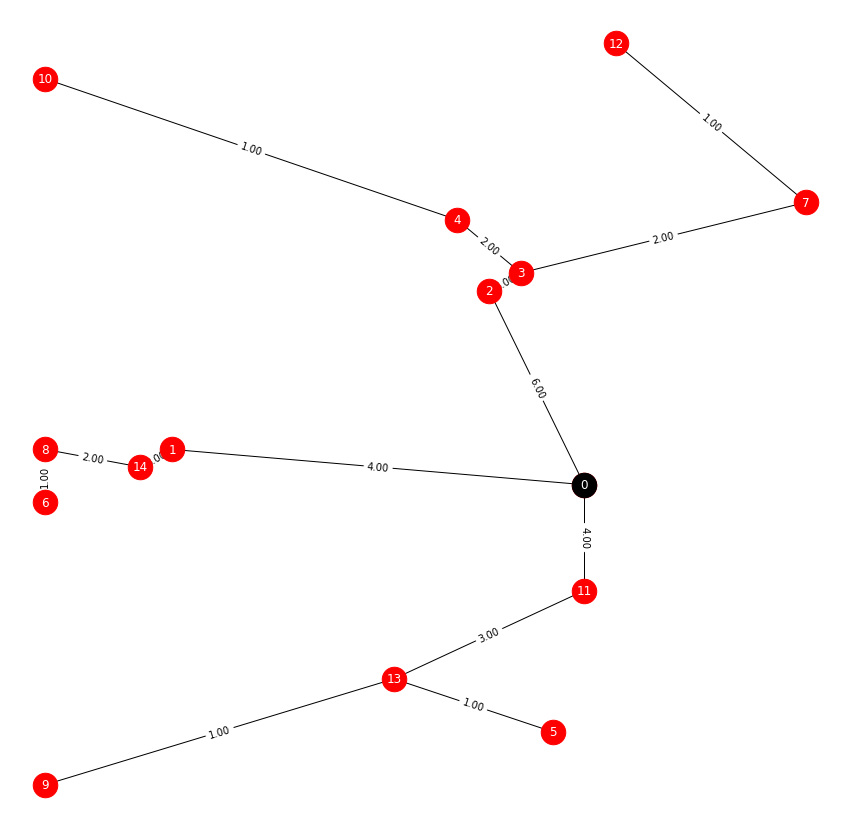

In [145]:
mstflow.optimize()
print("\n------------------------------------------------------------------------------------------------------------------------------------------------\n")
print("object val->", mstflow.objVal)
print("\n------------------------------------------------------------------------------------------------------------------------------------------------\n")
DrawSolFlow(G, x, f)

## **Ex.1.2 ->** Suppose that you can install in node 3 a hub with the following features:
    a. If the hub is installed, the cost of a link cost from node 3 to any other node decreases by a factor of 10;
    b. The hub accepts a maximum of 4 connections;
    c. An  adapter(cost:10  Euro)must  be  installed  in each node directly connected to the hub;
    d. Hub installation costs 100 Euro.

In [146]:
hub = 3
maxHubConnections = 4
adapterCost = 10
hubCost = 100

In [147]:
# (a)If the hub is installed, the cost of a link cost from node 3 to any other node decreases by a factor of 10;
H = G.copy()
hub = hub - 1 # the root is set to 0 so the third node is the second in our configuration

for i,j in H.edges():
    if(i == hub or j == hub):
        H[i][j]["cost"] = H[i][j]["cost"]//10
        H[i][j]["cost"] += 10 # c. An  adapter(cost:10  Euro)must  be  installed  in each node directly connected to the hub;


In [148]:
D = H.to_directed() # make a directed copy of H

mstflow = gb.Model()

## Variables

x = mstflow.addVars(H.edges(), obj=[H[u][v]['cost'] for u,v in H.edges()],
                    ub = 1.0,
                    vtype=gb.GRB.BINARY,
                    name='x')

f = mstflow.addVars(D.edges(), ub=H.number_of_nodes(), vtype=gb.GRB.CONTINUOUS, name='f')

## constraints

mstflow.addConstr(x.sum() == H.number_of_nodes() - 1, 'Cardinality')

mstflow.addConstr(f.sum(root, '*') - f.sum('*', root) == H.number_of_nodes() - 1, 'Flow_at_root')

# Root is the first nodes the iterator moves one step ahead
for v in H.nodes():
    if v != root:
        name = 'Balance_' + str(v)
        mstflow.addConstr(f.sum('*',v) - f.sum(v,'*') == 1, name=name)
    
for e in H.edges():
    
    h = e[0]
    k = e[1]
        
    name = "Force_f(%d,%d)_x(%d,%d)" % (h, k, e[0], e[1])
    mstflow.addConstr(f[h,k] <= (H.number_of_nodes() - 1) * x[e], name=name)

    name = "Force_f(%d,%d)_x(%d,%d)" % (k, h, e[0], e[1])
    mstflow.addConstr(f[k,h] <= (H.number_of_nodes() - 1) * x[e], name=name)

mstflow.update()
mstflow.write('mst.lp')

In [149]:
# (b)The hub accepts a maximum of 4 connections;
mstflow.addConstr(x.sum(hub, '*') + x.sum('*', hub)  <= maxHubConnections, name='maxHubConnections')

mstflow.update()
mstflow.write('mst.lp')

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 227 rows, 315 columns and 959 nonzeros
Model fingerprint: 0x07ad7029
Variable types: 210 continuous, 105 integer (105 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [2e+01, 5e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 25459.000000
Presolve time: 0.00s
Presolved: 227 rows, 315 columns, 959 nonzeros
Variable types: 210 continuous, 105 integer (105 binary)

Root relaxation: objective 4.689000e+03, 208 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4689.00000    0    6 25459.0000 4689.00000  81.6%     -    0s
H    0     0                    8769.0000000 4689.00000  46.5%     -    0s
H    0    

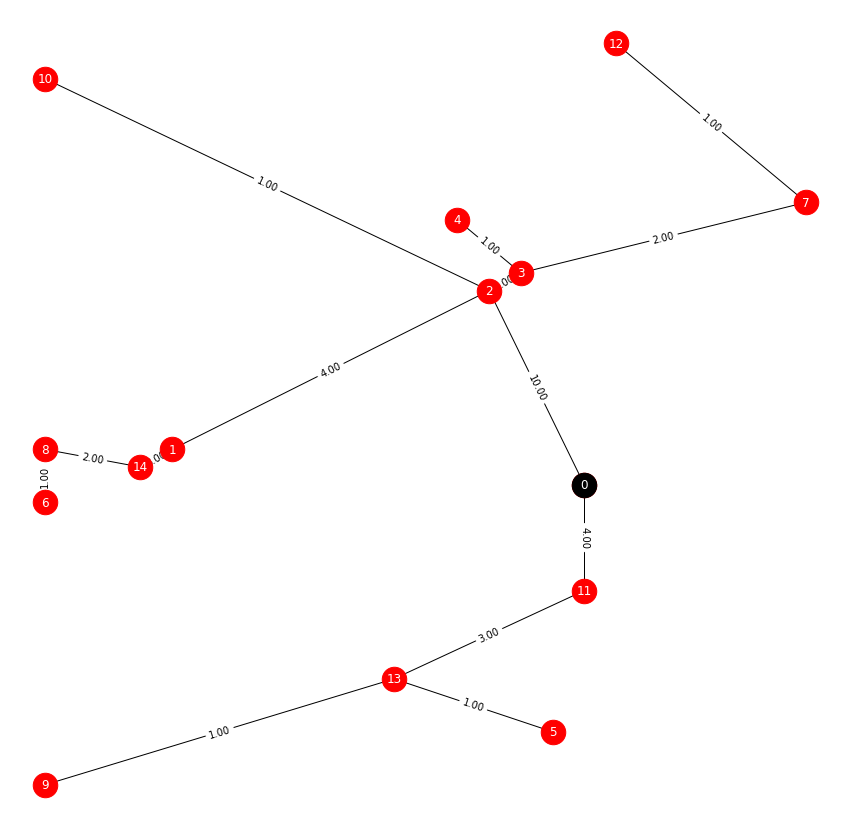

In [150]:
mstflow.optimize()

totalCost = mstflow.objVal + 100 # d. Hub installation costs 100 Euro.
print("\n------------------------------------------------------------------------------------------------------------------------------------------------\n")
print("totalCost ->", totalCost)
print("\n------------------------------------------------------------------------------------------------------------------------------------------------\n")
DrawSolFlow(H, x, f)

In Ex1.1 the total cost was 10520€, now it is  6984€, so **is is convenient to install an hub in node 3**